In [ ]:
# %%
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Necessary for 3D plotting
import os
import datetime
import joblib

dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update as needed


In [ ]:
# # ---------------------------
# # Parameters and Setup
# # ---------------------------
# # %% [markdown]
# # ## Parameter Definition
# # You can later inject these parameters via Papermill if desired.

# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "k-means-seed-100percent"  # Change as desired
# year = "2018"
# model = "kmeans-seeded"  # Change as desired

# # Define output folder and create it
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

# # %% [markdown]
# # ## Parameter Definition
# # You can later inject these parameters via Papermill if desired.
# dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
# sample_fraction = 0.05  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
# run_name = "logreg_run1-100percent"  # Change as desired
# year = "2018"
# model = "logreg"  # Change as desired

# # Define output folder and create it if needed
# output_folder = os.path.join("Outputs", year, model, run_name)
# os.makedirs(output_folder, exist_ok=True)
# print("Output folder created:", output_folder)

import os

# 1. Parameters and Setup
dataset_path = "/Users/book_kuno/Desktop/ddos_datasets/2018.csv"  # Update path as needed
sample_fraction = 0.005  # Use 1 for 100% of data (change to e.g., 0.05 for 5%)
run_name = "k-seed_run1-100percent"  # Change as desired
model = "k-seed"  # Change as desired

# Extract the entire filename (without the extension) from the dataset_path.
filename = os.path.basename(dataset_path)  # e.g., "2018.csv"
csv_name = os.path.splitext(filename)[0]    # e.g., "2018" or "MyDataset" if the file is named that way

# Use csv_name as the dynamic folder name
output_folder = os.path.join("Outputs", csv_name, model, run_name)
os.makedirs(output_folder, exist_ok=True)
print("Output folder created:", output_folder)


Output folder created: Outputs/k-means-seeded/kmeans_seeded_run1-5percent


In [16]:
# Load the dataset and display basic information
data = pd.read_csv(dataset_path)
print("Original dataset shape:", data.shape)

# Load the dataset and display basic information
print("First few rows of data:")
print(data.head())
print("\nDataset info:")
print(data.info())
print("\nClass distribution:")
print(data['label'].value_counts())



/var/folders/_f/tfp8h_wd35n8t6c1bystkdph0000gn/T/ipykernel_48129/2847398246.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


Original dataset shape: (4339651, 26)
First few rows of data:
    timestamp  Dst Port protocol  Flow Duration  Flow Duration_rolling_mean  \
0  1518745716   55250.0      6.0       958807.0                   1815614.1   
1  1519099848     443.0      6.0      6081730.0                   2284039.7   
2  1519179901   52453.0      6.0         1428.0                      6703.5   
3  1518659728    3389.0      6.0      2169521.0                   9191415.4   
4  1519116456   49913.0      6.0           97.0                  24709922.5   

   Flow Duration_rolling_std  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0               1.965582e+06           5.0           3.0            935.0   
1               2.888929e+06          10.0          12.0            646.0   
2               8.135168e+03           5.0           2.0            935.0   
3               2.752269e+07           8.0           7.0           1132.0   
4               4.818137e+07           3.0           1.0             31.0   



In [17]:
# Sample a fraction of the dataset (if needed)
data = data.sample(frac=sample_fraction, random_state=42)
# Remove rows where the 'label' column equals 'Label'
data = data[data['label'] != 'Label']
print(f"Dataset shape after sampling {sample_fraction*100:.0f}%:", data.shape)
# Reset the index to ensure continuity after sampling
data = data.reset_index(drop=True)

Dataset shape after sampling 5%: (216983, 26)


In [18]:
# Verify the unique labels after filtering
unique_labels = data['label'].unique()
print("Unique labels after filtering:")
print(unique_labels)


# %% [code]
# #### Dynamically Encode the Labels
# Use factorization to automatically assign integer labels.
data['label'], uniques = pd.factorize(data['label'])
print("\nEncoded labels mapping:")
print(dict(enumerate(uniques)))

Unique labels after filtering:
['Benign' 'DoS attacks-Hulk' 'DDoS attacks-LOIC-HTTP' 'DDOS attack-HOIC'
 'DoS attacks-SlowHTTPTest' 'DoS attacks-GoldenEye'
 'DoS attacks-Slowloris' 'DDOS attack-LOIC-UDP']

Encoded labels mapping:
{0: 'Benign', 1: 'DoS attacks-Hulk', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DDOS attack-HOIC', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}


In [19]:
# Print out all columns in the dataset for inspection
print("All columns in the dataset:")
print(data.columns.tolist())

# Option 1: Manually define the features you want to use.
# Uncomment and edit the following line to manually specify features.
manual_features = ['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max', 
                   'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol', 
                   'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration', 
                   'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max', 
                   'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max', 
                   'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 
                   'entropy_pkt_len']

# Option 2: If you don't manually define features, automatically select all columns except 'timestamp' and 'label'
try:
    # Use manual_features if defined
    selected_features = manual_features
except NameError:
    # Otherwise, automatically select columns
    selected_features = [col for col in data.columns if col.lower() not in ['timestamp', 'label']]

print("\nSelected features:")
print(selected_features)

X = data[selected_features]
y = data['label']

All columns in the dataset:
['timestamp', 'Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'label']

Selected features:
['pkts_ratio', 'Tot Bwd Pkts', 'Dst Port', 'Fwd Pkt Len Max', 'SYN Flag Cnt', 'byte_per_duration', 'Bwd Pkt Len Min', 'protocol', 'Fwd Pkt Len Mean', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow Duration', 'Flow Duration_rolling_std', 'Flow Duration_rolling_mean', 'Bwd Pkt Len Max', 'Fwd IAT Tot', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd IAT Max', 'Tot Fwd Pkts', 'Fwd IAT Min', 'Fwd IAT Mean', 'Fwd Pkt Len Std', 'entropy_pkt_len']


In [20]:
# Preprocess Data: Count rows before dropping missing values
num_rows_before = X.shape[0]
# Drop rows with missing values
X = X.dropna()
# Count rows after dropping missing values
num_rows_after = X.shape[0]
# Calculate and print the number of rows dropped
rows_dropped = num_rows_before - num_rows_after
print("Number of rows dropped due to missing values:", rows_dropped)

Number of rows dropped due to missing values: 0


In [21]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# If needed, encode the labels dynamically (if not already numeric)
if not np.issubdtype(y.dtype, np.number):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    # Create a mapping from original labels to their encoded values
    label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print("Label mapping:")
    print(label_mapping)
    # Replace y with its encoded version
    y = y_encoded
else:
    print("Labels are already numeric.")

Labels are already numeric.


Cumulative Explained Variance:
Components 1-1: 0.1970
Components 1-2: 0.3677
Components 1-3: 0.4937
Components 1-4: 0.5968
Components 1-5: 0.6805
Components 1-6: 0.7510
Components 1-7: 0.8102
Components 1-8: 0.8506
Components 1-9: 0.8876
Components 1-10: 0.9202
Components 1-11: 0.9420
Components 1-12: 0.9592
Components 1-13: 0.9701
Components 1-14: 0.9787
Components 1-15: 0.9869


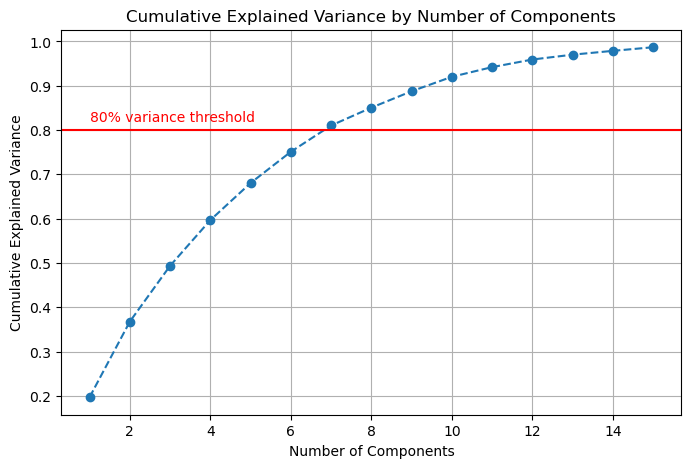

In [23]:
# ---------------------------
# 1. PCA for Variance Analysis (Full PCA)
# ---------------------------

# Fit PCA 
pca_full = PCA(n_components=15)
pca_full.fit(X_scaled)
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
# Print out cumulative variance for each number of components
print("Cumulative Explained Variance:")
for i, var in enumerate(cumulative_variance, start=1):
    print(f"Components 1-{i}: {var:.4f}")

# Plot cumulative explained variance vs. number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='-')  # For example, a line at 80%
plt.text(1, 0.82, '80% variance threshold', color='red')
plt.grid(True)
plt.show()


In [24]:
# ---------------------------
# PCA for Clustering Transformation $$$$$$$$$$$$$$$$$$$$$$$$$$
# ---------------------------
# Choose the number of components based on variance analysis (e.g., 8 components)
pca_clustering = PCA(n_components=10)
X_pca_clust = pca_clustering.fit_transform(X_scaled)
print("\nExplained variance ratio (clustering PCA):")
print(pca_clustering.explained_variance_ratio_)

# Save the clustering PCA model (optional)
joblib.dump(pca_clustering, os.path.join(output_folder, "pca_clustering_model.pkl"))


Explained variance ratio (clustering PCA):
[0.1969714  0.1707019  0.12599092 0.10309503 0.08370904 0.07056023
 0.05921633 0.04033048 0.03702443 0.03260344]


['Outputs/k-means-seeded/kmeans_seeded_run1-5percent/pca_clustering_model.pkl']

In [27]:
# =====================================================
# Seeding Initialization for K-Means Using Labeled Data
# =====================================================

# Sample a fixed number of points per label to compute initial centers
samples_per_label = 5  # You can adjust this number (e.g., 10 or 20) for a more robust estimate

# Group by label and sample a few points from each group.
# Note: data has already been factorized and y is numeric.
labeled_data = data.groupby('label').apply(lambda group: group.sample(n=samples_per_label, random_state=42))
# The MultiIndex returned contains the original row indices at level 1.
labeled_indices = labeled_data.index.get_level_values(1)

# Subset standardized features using these indices
X_labeled = X_pca_clust[labeled_indices]
y_labeled = y.iloc[labeled_indices]

# Compute initial centers: For each unique label, take the mean of its sampled points.
unique_labels = np.unique(y_labeled)
initial_centers = np.array([X_labeled[y_labeled == label].mean(axis=0) for label in unique_labels])
print("Initial centers computed for each label (seeded initialization):")
print(initial_centers)

Initial centers computed for each label (seeded initialization):
[[-4.99598440e-01 -1.09198571e+00  2.31708569e-01  1.71774459e+00
   7.29843933e-02 -1.93844309e-01  2.26518433e-01  1.98911706e-01
   6.45784941e-03  7.54522989e-03]
 [-1.10947860e+00 -5.56620556e-01 -1.77247509e-01 -1.60398892e+00
   1.65400398e-01 -1.75786366e-01  7.47848608e-02  4.38476998e-01
   2.80656026e-01  1.47955793e-01]
 [ 4.41115978e-01 -9.98727910e-01 -4.01722091e-01 -8.61251716e-01
   3.25445170e-02 -1.37884113e-01 -3.88249234e-01 -1.03400741e+00
  -5.02829916e-01 -1.88397881e-02]
 [-1.12773118e+00 -2.84503559e-02 -1.21988978e-01 -1.63461149e+00
   1.66785774e-01 -9.04161365e-02 -5.19487247e-02  6.38047245e-01
   5.13349265e-01  2.45666792e-01]
 [-1.16536188e+00 -4.23333462e-01 -1.48180202e-01 -1.46273865e+00
   1.34981798e-01 -7.11651670e-02  1.21687939e-01  3.60755798e-01
   8.11794821e-02  7.59933837e-01]
 [ 4.87787357e+00 -2.51899764e+00 -1.33200114e+00 -3.23713888e-01
  -1.17073894e+00  3.26888344e+00 

/var/folders/_f/tfp8h_wd35n8t6c1bystkdph0000gn/T/ipykernel_48129/2724305212.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  labeled_data = data.groupby('label').apply(lambda group: group.sample(n=samples_per_label, random_state=42))


In [28]:
# ---------------------------
# Run Seeded K-Means Clustering (in PCA Space)
# ---------------------------

# Assume X_pca_clust has been computed from a PCA transformation used for clustering.
# Also assume that `unique_labels` and `initial_centers` have been computed from your labeled data.

# Flag to choose between running only one k (seeded) or evaluating a range of k values.
evaluate_all_k = False  # Set to True to evaluate over a range; False to run only the seeded k.

if not evaluate_all_k:
    # Use k equal to the number of unique labels (seeded approach)
    optimal_k = len(unique_labels)
    # optimal_k = n
    print(f"Running seeded K-Means with k = {optimal_k}")
    
    seeded_kmeans = KMeans(n_clusters=optimal_k, init=initial_centers, n_init=1, max_iter=300, random_state=42)
    seeded_kmeans.fit(X_pca_clust)
    cluster_labels = seeded_kmeans.labels_
    
    # Save the seeded K-Means model
    seeded_model_path = os.path.join(output_folder, f"seeded_kmeans_model_k{optimal_k}.pkl")
    joblib.dump(seeded_kmeans, seeded_model_path)
    print("Seeded K-Means model saved at:", seeded_model_path)
    
    # Evaluate seeded model
    sil = silhouette_score(X_pca_clust, cluster_labels)
    ch = calinski_harabasz_score(X_pca_clust, cluster_labels)
    wcss_seeded = seeded_kmeans.inertia_
    print(f"Seeded model metrics: Silhouette={sil:.4f}, Calinski-Harabasz={ch:.2f}, WCSS={wcss_seeded:.2f}")
    
    # Store metrics in a list for later saving if desired
    metrics_list = [{
        "k": optimal_k,
        "Silhouette Score": sil,
        "Calinski-Harabasz Score": ch,
        "WCSS": wcss_seeded
    }]
    
else:
    # Evaluate over a range of k values.
    k_range = range(2, 15)  # For example, k = 2 to 14.
    metrics_list = []
    models = {}
    
    for k in k_range:
        # Use seeded initialization if k equals the number of unique labels; otherwise use k-means++.
        if k == len(unique_labels):
            init_method = initial_centers
            n_init_val = 1
            print(f"Running seeded K-Means for k = {k}")
        else:
            init_method = 'k-means++'
            n_init_val = 10
            print(f"Running K-Means with k = {k}")
        
        kmeans_temp = KMeans(n_clusters=k, init=init_method, n_init=n_init_val, max_iter=300, random_state=42)
        kmeans_temp.fit(X_pca_clust)
        labels_temp = kmeans_temp.labels_
        
        # Evaluate the clustering
        sil = silhouette_score(X_pca_clust, labels_temp)
        ch = calinski_harabasz_score(X_pca_clust, labels_temp)
        wcss_val = kmeans_temp.inertia_
        
        metrics_list.append({
            "k": k,
            "Silhouette Score": sil,
            "Calinski-Harabasz Score": ch,
            "WCSS": wcss_val
        })
        
        models[k] = kmeans_temp
        
        # Save the model for this k value
        model_path = os.path.join(output_folder, f"kmeans_model_k{k}.pkl")
        joblib.dump(kmeans_temp, model_path)
        print(f"Saved K-Means model for k = {k} at {model_path}")
        
        # Optionally, you could also save per-k evaluation metrics in a subfolder.
    
    # Convert overall metrics to a DataFrame and save them as CSV.
    overall_metrics_df = pd.DataFrame(metrics_list)
    overall_metrics_csv_path = os.path.join(output_folder, "clustering_evaluation_metrics_overall.csv")
    overall_metrics_df.to_csv(overall_metrics_csv_path, index=False)
    print("Overall clustering evaluation metrics saved as CSV at:", overall_metrics_csv_path)
    
    # For subsequent steps, choose the final model based on your evaluation.
    # For demonstration, we'll load the model for k equal to the number of unique labels (if present),
    # or simply choose the first entry.
    if len(unique_labels) in k_range:
        optimal_k = len(unique_labels)
    else:
        optimal_k = metrics_list[0]["k"]
    seeded_kmeans = joblib.load(os.path.join(output_folder, f"kmeans_model_k{optimal_k}.pkl"))
    cluster_labels = seeded_kmeans.labels_

# Now cluster_labels is your final cluster assignment from the chosen model.

Running seeded K-Means with k = 8
Seeded K-Means model saved at: Outputs/k-means-seeded/kmeans_seeded_run1-5percent/seeded_kmeans_model_k8.pkl
Seeded model metrics: Silhouette=0.5618, Calinski-Harabasz=69888.71, WCSS=1472330.10


In [30]:
# =====================================================
# Cluster Alignment / Mapping
# =====================================================

# Factorize the label column (if not already done)
data['label'], uniques = pd.factorize(data['label'])
# Create a mapping from numeric codes to the original label names
label_names = {i: label for i, label in enumerate(uniques)}
print("Encoded labels mapping:")
print(label_names)

# Use label-based indexing to select the same rows used in clustering
data_subset = data.loc[X.index].copy()
data_subset['Cluster'] = cluster_labels

def align_clusters(data_subset, label_names):
    # Map clusters to their majority true label (using the 'label' column)
    cluster_mapping = (
        data_subset.groupby('Cluster')['label']
        .apply(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    # Create a human-readable mapping from cluster numbers to the original label names
    cluster_label_mapping = {cluster: label_names[true_label] for cluster, true_label in cluster_mapping.items()}
    # For clarity, add columns for the original (mapped) labels and the aligned (majority) label
    data_subset['Mapped Label'] = data_subset['label'].map(label_names)
    data_subset['Aligned Cluster'] = data_subset['Cluster'].map(cluster_mapping)
    return cluster_mapping, cluster_label_mapping, data_subset

normal_mapping, normal_label_mapping, data_normal = align_clusters(data_subset, label_names)
print("\nCluster Mapping (Aligned to Majority Labels):")
print(normal_label_mapping)

cluster_composition_normal = (
    data_normal.groupby('Cluster')['Mapped Label']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)
print("\nCluster Composition (Normalized):")
print(cluster_composition_normal)

# Save cluster alignment outputs as CSV
cluster_composition_normal.to_csv(os.path.join(output_folder, "cluster_composition.csv"), index=True)
pd.DataFrame(list(normal_label_mapping.items()), columns=["Cluster", "Mapped Label"]).to_csv(
    os.path.join(output_folder, "cluster_mapping.csv"), index=False)
data_normal.to_csv(os.path.join(output_folder, "data_with_clusters.csv"), index=False)
print("Cluster composition, mapping, and data with clusters saved as CSV.")

Encoded labels mapping:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

Cluster Mapping (Aligned to Majority Labels):
{0: 0, 1: 3, 2: 0, 3: 0, 4: 0, 5: 2, 6: 0, 7: 7}

Cluster Composition (Normalized):
Mapped Label         0         1         2         3         4         5  \
Cluster                                                                    
0             0.999756  0.000000  0.000066  0.000000  0.000000  0.000000   
1             0.084172  0.331186  0.079122  0.393223  0.106111  0.005655   
2             0.571723  0.019880  0.239432  0.138274  0.000000  0.029335   
3             0.999828  0.000000  0.000000  0.000000  0.000000  0.000172   
4             0.989575  0.000000  0.000000  0.000000  0.000000  0.001738   
5             0.013588  0.000000  0.933899  0.000000  0.000000  0.034123   
6             0.964417  0.006559  0.000270  0.000000  0.000000  0.000719   
7             0.000000  0.000000  0.336066  0.000000  0.000000  0.000000   

Mapped Label         6         7  



Explained variance ratio (2D PCA):
[0.1969714 0.1707019]
2D visualization data saved as CSV: Outputs/k-means-seeded/kmeans_seeded_run1-5percent/visualization_2D_data.csv


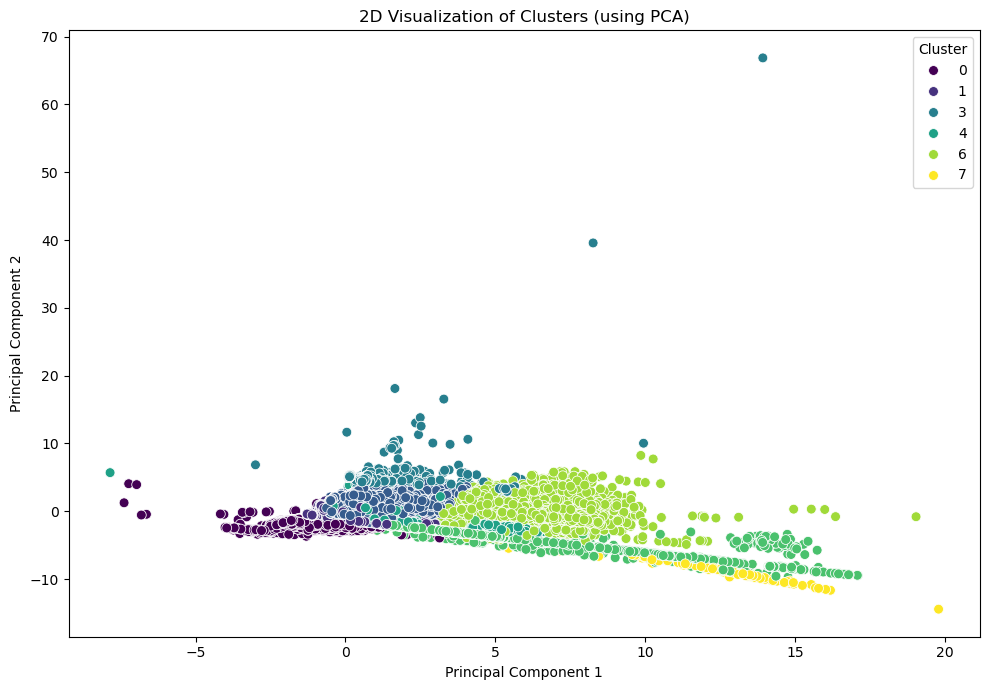


Explained variance ratio (3D PCA):
[0.1969714  0.1707019  0.12599092]
3D visualization data saved as CSV: Outputs/k-means-seeded/kmeans_seeded_run1-5percent/visualization_3D_data.csv


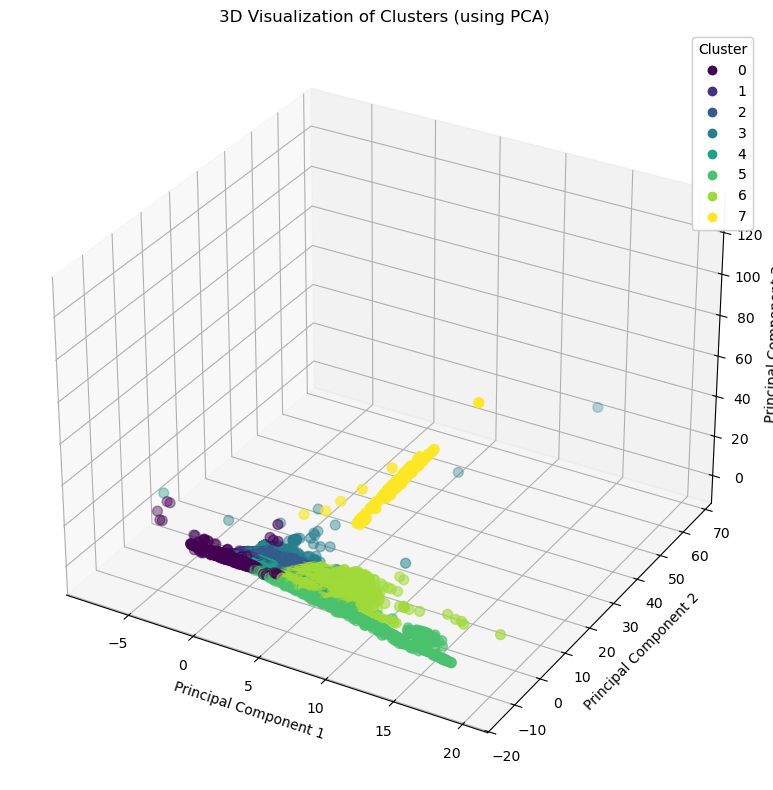

In [31]:
# ---------------------------
# 8. Visualization of Clusters: Both 2D and 3D
# ---------------------------

# ---- 2D Visualization ----
pca_vis_2d = PCA(n_components=2)
X_pca_2d = pca_vis_2d.fit_transform(X_scaled)
print("\nExplained variance ratio (2D PCA):")
print(pca_vis_2d.explained_variance_ratio_)

# Create DataFrame for 2D visualization
df_vis2d = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
df_vis2d["Cluster"] = cluster_labels
vis2d_csv_path = os.path.join(output_folder, "visualization_2D_data.csv")
df_vis2d.to_csv(vis2d_csv_path, index=False)
print("2D visualization data saved as CSV:", vis2d_csv_path)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title("2D Visualization of Clusters (using PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
vis2d_path = os.path.join(output_folder, "clusters_2D.png")
plt.savefig(vis2d_path, bbox_inches='tight')
plt.show()

# ---- 3D Visualization ----
pca_vis_3d = PCA(n_components=3)
X_pca_3d = pca_vis_3d.fit_transform(X_scaled)
print("\nExplained variance ratio (3D PCA):")
print(pca_vis_3d.explained_variance_ratio_)

# Create DataFrame for 3D visualization
df_vis3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
df_vis3d["Cluster"] = cluster_labels
vis3d_csv_path = os.path.join(output_folder, "visualization_3D_data.csv")
df_vis3d.to_csv(vis3d_csv_path, index=False)
print("3D visualization data saved as CSV:", vis3d_csv_path)

from mpl_toolkits.mplot3d import Axes3D  # Import necessary for 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=cluster_labels, cmap='viridis', s=50)
ax.set_title("3D Visualization of Clusters (using PCA)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.tight_layout()
vis3d_path = os.path.join(output_folder, "clusters_3D.png")
plt.savefig(vis3d_path, bbox_inches='tight')
plt.show()

In [35]:
# =====================================================
# Save Models and Preprocessing Artifacts
# =====================================================
joblib.dump(pca_full, os.path.join(output_folder, "pca_full_model.pkl"))
joblib.dump(pca_clustering, os.path.join(output_folder, "pca_clustering_model.pkl"))
joblib.dump(pca_vis_2d, os.path.join(output_folder, "pca_visualization_model_2D.pkl"))
joblib.dump(pca_vis_3d, os.path.join(output_folder, "pca_visualization_model_3D.pkl"))
joblib.dump(seeded_kmeans, os.path.join(output_folder, "kmeans_seeded_model.pkl"))
joblib.dump(scaler, os.path.join(output_folder, "scaler.pkl"))
print("PCA models, K-Means model, and scaler saved.")

# =====================================================
# Save Additional Evaluation Plots and Metrics
# =====================================================
# Save PCA explained variance ratio to a text file
with open(os.path.join(output_folder, "pca_explained_variance.txt"), "w") as f:
    f.write("Explained Variance Ratio (Full PCA):\n")
    f.write(str(pca_full.explained_variance_ratio_))
print("PCA explained variance ratio saved.")

# # Save Elbow Method plot as PNG (assuming you plotted it earlier)
# elbow_plot_path = os.path.join(output_folder, "elbow_method.png")
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(wcss) + 1), wcss, marker='o', linestyle='--')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(elbow_plot_path, bbox_inches='tight')
# plt.close()
# print("Elbow Method plot saved.")

print("\nAll outputs saved to:", output_folder)

PCA models, K-Means model, and scaler saved.
PCA explained variance ratio saved.

All outputs saved to: Outputs/k-means-seeded/kmeans_seeded_run1-5percent
